# cmip Events

Get the indeces from traditional and EC calcs and determine events

In [3]:
_work_dir='/g/data/gv90/as2285/compound/'
import sys
sys.path.append(_work_dir)

In [4]:
import xarray
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches


In [5]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound
import utils.overlapBins as overlapBins


# Find events 

In [6]:
#open events in the trad indeces
tradIndecesXr = xarray.concat([
    xarray.open_dataset(f'{_work_dir}results/cmip6{experiment}TradIndecesTos.nc').sel(model=_model.scenarioMip[:,1]) for experiment in ['piControl','ssp585']], 
'experiment')

tradIndecesXr['experiment']=['piControl','ssp585']



In [7]:
piControlXr=tradIndecesXr.sel(experiment='piControl',drop=True)

piControlXr.model.values

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM',
       'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'CanESM5-CanOE', 'EC-Earth3', 'EC-Earth3-CC',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'GFDL-CM4', 'GFDL-ESM4',
       'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM',
       'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)

In [8]:
stdXr = piControlXr.std(dim='year')

criteriaXr= xarray.merge(
    (stdXr[['nino3','nino34','nino4','dmi','eastIO']],
     stdXr[['samWinter','samSummer']]/2)
)

In [9]:
firePos, fireNeg = compound.applyCriteria(tradIndecesXr, criteriaXr)


firePos: 
['dmi', 'samWinter', 'nino4', 'nino34', 'nino3']
fireNeg: 
['eastIO', 'samSummer']


In [10]:
fireXr=xarray.concat([firePos,fireNeg], 'fire')
fireXr['fire']=['pos','neg']

In [11]:
fireXr

<xarray.Dataset>
Dimensions:     (fire: 2, experiment: 2, model: 35, year: 4997)
Coordinates:
  * year        (year) int64 1 2 3 4 5 6 7 ... 6194 6195 6196 6197 6198 6199
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * experiment  (experiment) <U9 'piControl' 'ssp585'
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    dmi         (fire, experiment, model, year) float64 nan nan nan ... nan nan
    samWinter   (fire, experiment, model, year) float64 nan nan nan ... nan nan
    nino4       (fire, experiment, model, year) float64 nan nan nan ... nan nan
    nino34      (fire, experiment, model, year) float64 nan nan nan ... nan nan
    nino3       (fire, experiment, model, year) float64 nan nan nan ... nan nan
    eastIO      (fire, experiment, model, year) float64 nan nan nan ... nan nan
    samSummer   (fire, experiment, model, year) float64 nan nan nan ... nan nan

# an attempt at a summary plot

In [12]:
indeces = [# 'ecCombined','dmi','samWinter','samSummer'
    'nino34','dmi','samWinter','samSummer']

In [13]:
summaryXr=fireXr[indeces].sel(
    experiment='ssp585', 
    year=slice(1850,2099),
    drop=True
)

In [14]:
nEventsCurrentXr=summaryXr.sel(year=slice(1950,1999),drop=True).sum('year')
nEventsFutureXr=summaryXr.sel(year=slice(2050,2099),drop=True).sum('year')


In [15]:
import scipy.stats as stats
for iIndex in indeces:
    print(iIndex)
    for iFire in ['pos','neg']:
        print(iFire)
        print(stats.kstest(
            nEventsCurrentXr[iIndex].sel(fire=iFire,drop=True),
            nEventsFutureXr[iIndex].sel(fire=iFire,drop=True)
        ))

nino34
pos
KstestResult(statistic=0.8, pvalue=2.1371147048109803e-11)
neg
KstestResult(statistic=0.37142857142857144, pvalue=0.015304525838472695)
dmi
pos
KstestResult(statistic=0.8285714285714286, pvalue=2.3374692083870097e-12)
neg
KstestResult(statistic=0.6, pvalue=3.4452298564531986e-06)
samWinter
pos
KstestResult(statistic=0.9714285714285714, pvalue=1.2479244585402055e-18)
neg
KstestResult(statistic=0.9714285714285714, pvalue=1.2479244585402055e-18)
samSummer
pos
KstestResult(statistic=0.9428571428571428, pvalue=4.305339381963709e-17)
neg
KstestResult(statistic=0.9714285714285714, pvalue=1.2479244585402055e-18)


# Observational impacts from compound modes

In [17]:
indexXr=xarray.open_dataset(f'{_work_dir}/results/obsIndeces.nc', chunks='auto')

In [18]:
eventsXr=xarray.open_dataset(f'{_work_dir}/results/obsEvents.nc', chunks='auto')

In [19]:
nObsEventsXr=eventsXr.sel(year=slice(1957,2006),drop=True).sum('year')

In [20]:
nObsEventsXr

<xarray.Dataset>
Dimensions:     (fire: 2)
Coordinates:
    mode        int64 ...
  * fire        (fire) object 'pos' 'neg'
Data variables:
    nino34      (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    samWinter   (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    eIndex      (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nino4       (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    nino3       (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    dmi         (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    cIndex      (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    samSummer   (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    eastIO      (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    ecCombined  (fire) float64 dask.array<chunksize=(2,), meta=np.ndarray>

In [21]:
#anoms have already been calculated - see prelim/adcdPrTAnoms.ipynb file
impactXr=xarray.open_dataset(f'{_work_dir}/results/observPrTmaxAnoms.nc', chunks='auto').sel(year=slice(1940,2019))

In [22]:
impactXr

<xarray.Dataset>
Dimensions:       (lat: 691, lon: 886, year: 80)
Coordinates:
  * lat           (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon           (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.2 156.2
  * year          (year) int64 1940 1941 1942 1943 1944 ... 2016 2017 2018 2019
Data variables:
    tsAnomWinter  (year, lat, lon) float32 dask.array<chunksize=(52, 532, 683), meta=np.ndarray>
    tsAnomSummer  (year, lat, lon) float32 dask.array<chunksize=(52, 532, 683), meta=np.ndarray>
    prAnomWinter  (year, lat, lon) float64 dask.array<chunksize=(33, 422, 542), meta=np.ndarray>
    prAnomSummer  (year, lat, lon) float64 dask.array<chunksize=(33, 422, 542), meta=np.ndarray>
    prWinter      (lat, lon) float64 dask.array<chunksize=(691, 886), meta=np.ndarray>
    prSummer      (lat, lon) float64 dask.array<chunksize=(691, 886), meta=np.ndarray>
    tsWinter      (lat, lon) float32 dask.array<chunksize=(691, 886), meta=np.ndarray>
    tsSummer      (lat, lon) float32 dask.array<chunksize=(691, 886), meta=np.ndarray>

In [23]:
import cmocean.cm as cmo
import matplotlib.ticker as mticker


In [24]:
%matplotlib inline

/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/gv90/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/jobfs/88285471.gadi-pbs/ipykernel_1791076/3414589711.py:89: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the 

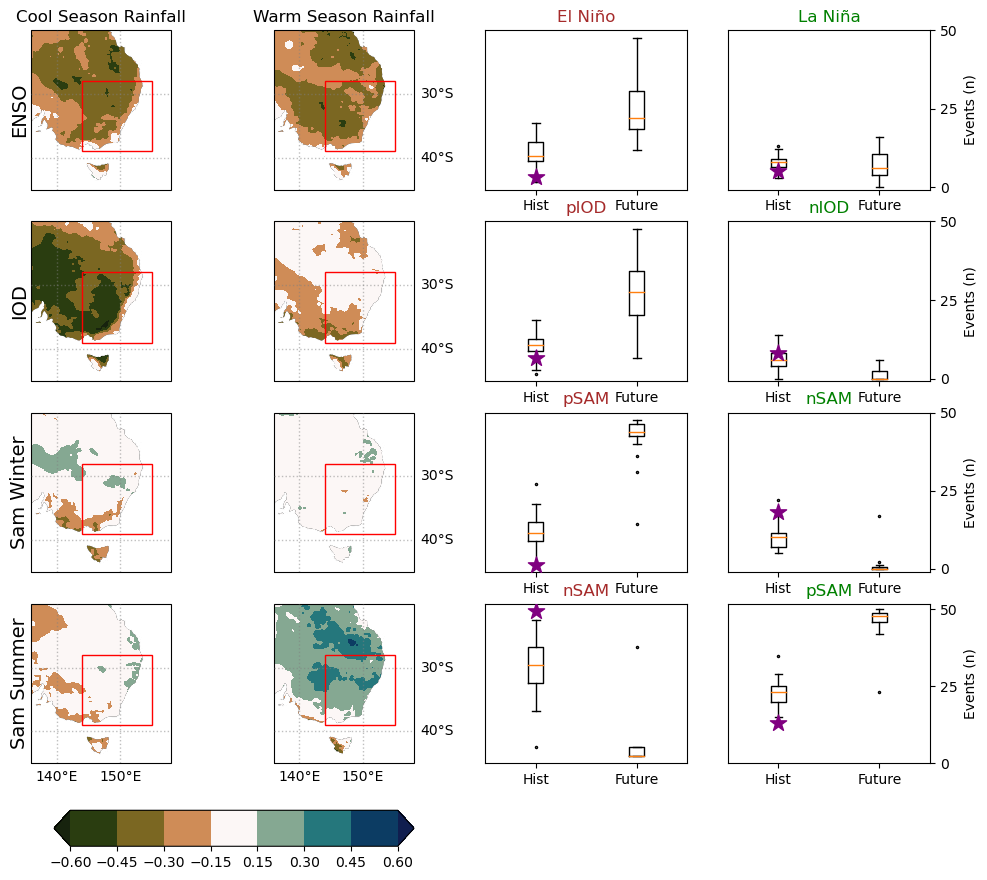

In [32]:
#how many columns
nCols=4
nIndex=4

fig = plt.figure(figsize=(12,12))

axs=list()

#for each row
for iIndex in [['nino34','ENSO','El Niño', 'La Niña',0],
    ['dmi', 'IOD','pIOD','nIOD',1 ],
    ['samWinter','Sam Winter','pSAM','nSAM',2],
    ['samSummer','Sam Summer','nSAM','pSAM',3]]:

    #for each column
    for i in range(0,2):
        
        iPr, iLabel=[['prAnomWinter','Cool Season Rainfall'],
        ['prAnomSummer','Warm Season Rainfall']][i]

        if (~((iIndex[0]=='samWinter')&(iPr=='prAnomSummer'))
              &~((iIndex[0]=='samSummer')&(iPr=='prAnomWinter'))
             ):

            #make a sub plot
            ax=fig.add_subplot(
                nIndex+1, #how many rows
                nCols, #how many columns
                i+1+iIndex[4]*(nCols), # index
                projection=ccrs.PlateCarree()
            )

            plt.xlim([136,158])
            plt.ylim([-45,-20])

            iCorr=xarray.corr(indexXr[iIndex[0]],impactXr[iPr],'year')

            levels=[-0.6,-0.45,-0.3,-0.15,0.15,0.3,0.45,0.6]

            plt.contourf(
                iCorr.lon,
                iCorr.lat,
                iCorr,
                levels=levels,
                extend='both',
                cmap=cmo.tarn
            )

            ax.coastlines()
            ax.add_feature(cfeature.OCEAN,zorder=2,color='white')

            #in the first column, put a y-label
            if i==0:
                ax.text(-0.15, 0.5,  #xy relative to bottom left of axis
                        str(iIndex[1]),
                        rotation='vertical', transform=ax.transAxes, 
                        verticalalignment='center',fontsize=14)

            #in the first row put a heading
            if iIndex[4]==0 :
                ax.set_title(iLabel)

            axs.append(ax)

            # draw long/lat lines, with right and bottom labels
            gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':',zorder=3)
            gl.top_labels=False
            gl.left_labels=False
            if iIndex[4]!=3:
                gl.bottom_labels=False
            if i==0:
                gl.right_labels=False
            gl.xlocator = mticker.FixedLocator([120, 130, 140, 150, 160])
            gl.ylocator = mticker.FixedLocator([-50,-40,-30,-20,-10,0])

            #are of interest
            ax.add_patch(
                mpatches.Rectangle(
                    xy=[144, -39], 
                    width=11, height=11,
                    edgecolor='red',facecolor='none',
                    zorder=3
                ),
            )
        
    if iIndex[4]==3:
        # put a color bar on
        axs.append(fig.add_axes([0.17,0.2,0.3,0.03]))
        cbar=plt.colorbar(
            orientation='horizontal', 
            cax=axs[-1], 
            extend='both', 
        )
    
    #firepos
    i=2
    
    #make a sub plot
    ax=fig.add_subplot( len(indeces)+1, nCols, i+1+iIndex[4]*(nCols))
    
    #current and future boxplot
    
    plt.boxplot([
        nEventsCurrentXr[iIndex[0]].sel(fire='pos',drop=True),
        nEventsFutureXr[iIndex[0]].sel(fire='pos',drop=True)
    ], flierprops={'markersize':1.5})
    
    plt.scatter(
        1,
        nObsEventsXr[iIndex[0]].sel(fire='pos',drop=True),
        marker='*', color='purple', s=150, zorder=200 
    )
    
    #xlabels
    plt.xticks(ticks=[1,2],labels=['Hist','Future'])
    
    #title
    plt.title(iIndex[2], color='brown')
    
    #ylabels
    if i==3:
        plt.yticks(ticks=[0,25,50])
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
    else:
        plt.yticks([])
    
    #fireneg
    i=3
    
    #make a sub plot
    ax=fig.add_subplot(
        len(indeces)+1, #how many rows
        nCols, #how many columns
        i+1+iIndex[4]*(nCols), # index
    )
    
    #current and future boxplot
    plt.boxplot([
        nEventsCurrentXr[iIndex[0]].sel(fire='neg',drop=True),
        nEventsFutureXr[iIndex[0]].sel(fire='neg',drop=True)
    ], flierprops={'markersize':1.5})
    
    plt.scatter(
        1,
        nObsEventsXr[iIndex[0]].sel(fire='neg',drop=True),
        marker='*', color='purple', s=150, zorder=200 
    )
    
    # if iIndex==0:
    plt.title(iIndex[3], color='green')
    
    #xlabels
    plt.xticks(ticks=[1,2],labels=['Hist','Future'])
    
    #ylabels
    if i==3:
        plt.yticks(ticks=[0,25,50])
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        
        plt.ylabel('Events (n)')
    else:
        plt.yticks([])

axs[5].set_alpha(0.2)
axs[6].set_alpha(0.2)

# plt.subplots_adjust(hspace=0.05,wspace=0.05)

# plt.savefig(f'{_work_dir}/figures/singleEventsSummary.pdf')


In [26]:
axs[5].set_alpha(0.2)

In [ ]:
axs[5].clear()

In [ ]:
axs[5].clear()

In [ ]:
plt.show()

In [ ]:
plt.draw()

In [ ]:
plt.ioff()

In [ ]:
cmo.tarn

In [ ]:
plt.figure()
ax=plt.subplot(projection=ccrs.PlateCarree())
           
iCorr=xarray.corr(indexXr.nino34, impactXr.prAnomWinter, 'year')

levels=numpy.arange(-0.75,0.75,0.1)
    
plt.contourf(
    iCorr.lon,
    iCorr.lat,
    iCorr,
    levels=levels,
    extend='both',
    cmap=cmo.curl
)

plt.xlim([136,158])
plt.ylim([-45,-18])

ax.set_title('Nino34 and Cool Season Rain')
ax.coastlines()
           
ax.add_feature(cfeature.OCEAN,zorder=2,color='white')

# draw long/lat lines, with right and bottom labels
gl=ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle=':',zorder=3)
gl.top_labels=False
gl.left_labels=False
gl.xlocator = mticker.FixedLocator([120, 130, 140, 150, 160])
gl.ylocator = mticker.FixedLocator([-50,-40,-30,-20,-10,0])

plt.colorbar()

In [ ]:
xarray.corr(indexXr.samWinter, impactXr.prAnomWinter, 'year').plot()

In [ ]:
eventsLs = {
    'summer':['nino34', 'dmi','samSummer'],
    'winter':['nino34','dmi','samWinter']
}

I am calculating rainfall trends as a percent of the annual rain fall, by austral season

In [ ]:
#change rainfall into % 
prXr=xarray.Dataset()
prXr['Winter Rain']=(impactXr.prAnomWinter/(impactXr['prWinter']+impactXr['prSummer'])*100)
prXr['Summer Rain']=(impactXr.prAnomSummer/(impactXr['prWinter']+impactXr['prSummer'])*100)

tsXr=(impactXr[['tsAnomWinter','tsAnomSummer']])
tsXr=tsXr.rename({'tsAnomWinter':'Winter Temp','tsAnomSummer':'Summer Temp'})

In [ ]:
detrendTsXr=tsXr-tsXr.rolling(year=11,min_periods=5,center=True).mean('year')

In [ ]:
detrendTsXr

# Anoms for indiv indices

This would plot impacts from each index, if interested:

In [ ]:
%run {_work_dir}/helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=indexPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason], #names of event types
            stipling=False,
            showOcean=False,
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
                
        plt.show()
        
        axs=indexPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            stipling=False,
            showOcean=False,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].text(
            -0.1, 0.5,  #xy relative to bottom left of axis
            '1957-2019', #yearRange
            rotation='vertical', 
            transform=axs[0].transAxes, 
            verticalalignment='center',
            fontsize=14
        )
        plt.show()